<a href="https://colab.research.google.com/github/fquaker/bike_rental/blob/main/bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing
## Contexto
- Los sistemas alquiler de bicicletas (públicos o no), están en auge en todo el mundo, aún más después de la pandemia de Covid19.  
- Un problema recurrente en este tipo de sistemas es que al final de la jornada laboral las bicicleta tienden a concentrarse en ciertas puntos de la ciudad, donde las personas viven o combinan con otros medios de transporte como trenes, subtes o autos propios.  
- Por otro lado, las estaciones céntricas suelen quedar vacías.  
- Al final día se suele volver a llenar estas estaciones con bicicletas almacenadas en depósitos.  
- Existe la hipótesis de que cuando el pronóstico de tiempo es "favorable", la gente suele preferir este medio, pero hasta un cierto umbral de temperatura en el cual el uso cae.  
- Supongamos que usted es parte de un equipo de Gobierno que diseña estas políticas de movilidad multimodal.  
- Se pretende obtener una estimación de la demanda de bicicletas para el día posterior, de manera de poder planificar la logística de los camiones que deben recorrer los depósitos.   
- Dataset: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset  

## Entregables
- Preguntas del cuestionario respondidas (se puede duplicar la notebook y contestarlas debajo).
- Notebooks de Jupyter Lab o Colab que resuelven el problema en la carpeta de Drive asignada.
- Presentación de no más de 12 slides planteando el problema y la resolución encontrada.
- Bonus opcional: Se puede grabar un video de no mas de 12 minutos explicando los slides.
- Fecha de entrega: 16/12/2021

**Ideas para ir probando**

---
- El horario en función de la estación. ¿Puede ser que en verano se usen hasta más tarde?

In [ ]:
!pip install \
	numpy==1.19.5 \
	scikit-learn==0.24.2 \
	pandas==1.3.1 \
	seaborn==0.11.1 \
	matplotlib==3.4.2 \
	pmdarima==1.8.2 \
	statsmodels==0.12.2 \
	urllib3==1.26.6

     |████████████████████████████████| 22.3 MB 32.2 MB/s 
     |████████████████████████████████| 11.5 MB 41.1 MB/s 
     |████████████████████████████████| 285 kB 31.7 MB/s 
     |████████████████████████████████| 10.3 MB 42.8 MB/s 
     |████████████████████████████████| 1.5 MB 49.7 MB/s 
     |████████████████████████████████| 9.5 MB 33.1 MB/s 
     |████████████████████████████████| 138 kB 56.7 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from numpy import log

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

Cargamos los datos

In [ ]:
url = "https://raw.githubusercontent.com/fquaker/bike_rental/main/datos%20bike/day.csv"

df_day = pd.read_csv(url, header= "infer", parse_dates=['dteday'], index_col='dteday')

url2 = "https://raw.githubusercontent.com/fquaker/bike_rental/main/datos%20bike/hour.csv"

df_hour = pd.read_csv(url2, header= "infer", parse_dates=['dteday'], index_col='dteday')


In [ ]:
df_day.info()
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 91.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 

Los chusmeamos crudos

In [ ]:
print(df_day.head(), df_day.tail())
print(df_hour.head(), df_hour.tail())

            instant  season  yr  mnth  ...  windspeed  casual  registered   cnt
dteday                                 ...                                     
2011-01-01        1       1   0     1  ...   0.160446     331         654   985
2011-01-02        2       1   0     1  ...   0.248539     131         670   801
2011-01-03        3       1   0     1  ...   0.248309     120        1229  1349
2011-01-04        4       1   0     1  ...   0.160296     108        1454  1562
2011-01-05        5       1   0     1  ...   0.186900      82        1518  1600

[5 rows x 15 columns]             instant  season  yr  mnth  ...  windspeed  casual  registered   cnt
dteday                                 ...                                     
2012-12-27      727       1   1    12  ...   0.350133     247        1867  2114
2012-12-28      728       1   1    12  ...   0.155471     644        2451  3095
2012-12-29      729       1   1    12  ...   0.124383     159        1182  1341
2012-12-30      7

Ploteamos junto con una media movil como para entender como se mueven

In [ ]:
def plot_df(df, x , y, title="", xlabel='Date', ylabel='Value', dpi=100):
    mpl.style.use("ggplot")
    plt.figure(figsize=(21,7), dpi=dpi)
    plt.plot(x, y, color='tab:olive')
    y.rolling(window =30).mean().plot()
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

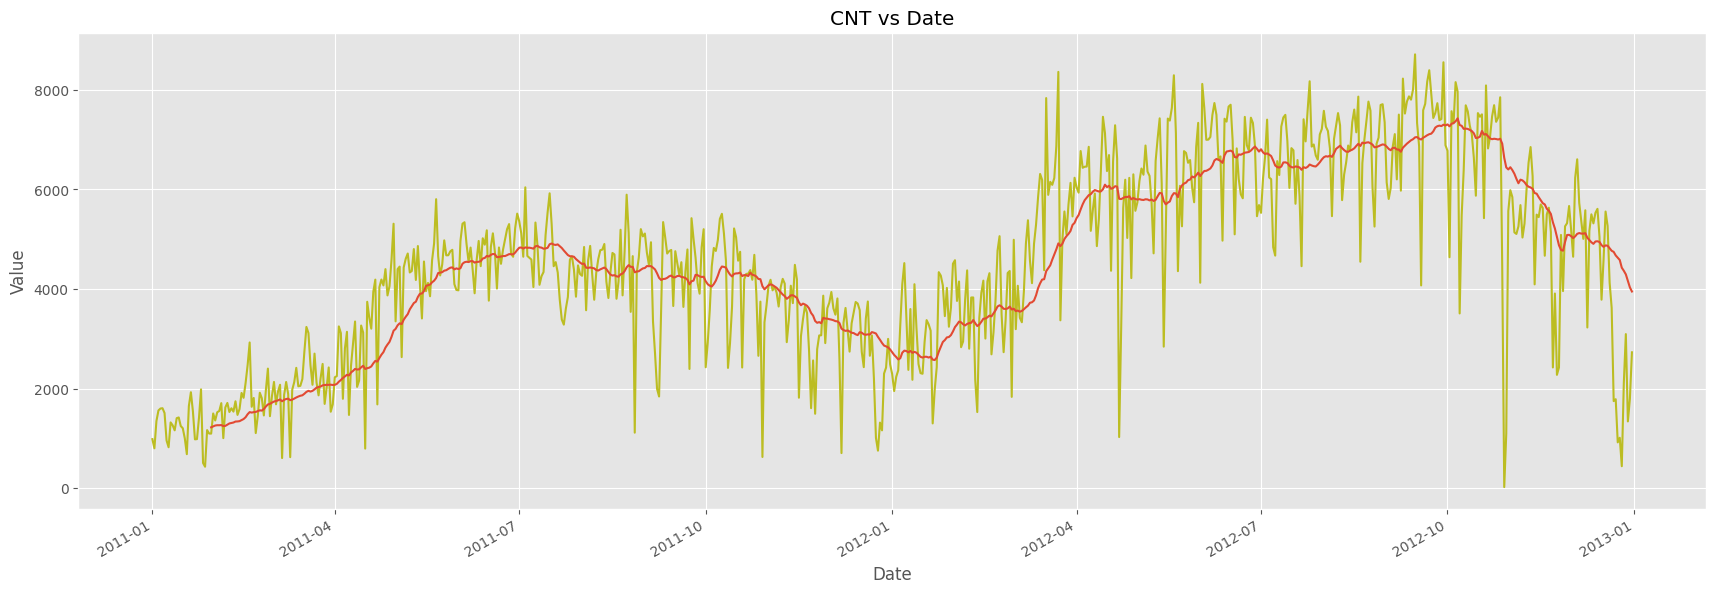

In [ ]:
plot_df(df =df_day, x=df_day.index, y=df_day.cnt, title='CNT vs Date')

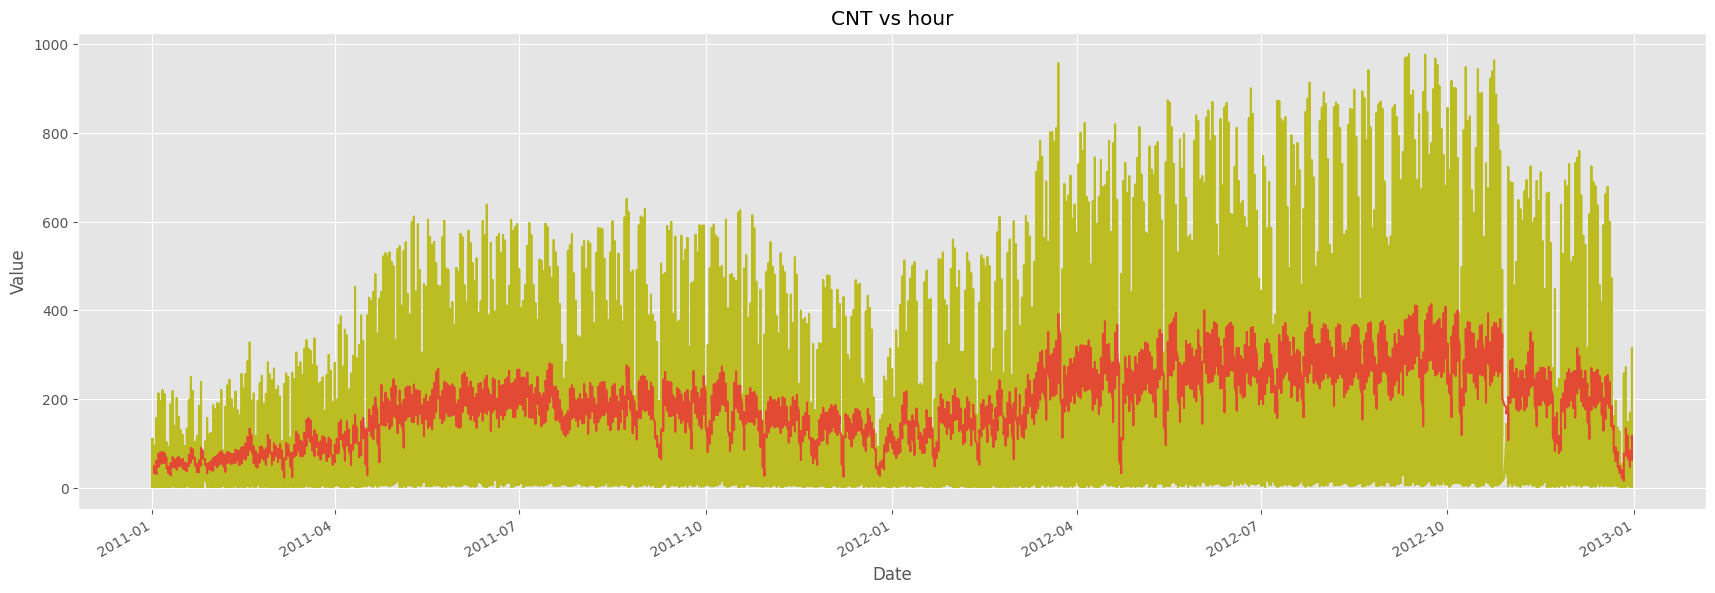

In [ ]:
plot_df(df =df_hour, x=df_hour.index, y=df_hour.cnt, title='CNT vs hour')

In [ ]:
season = 1
df_season = df_hour.loc[df_hour.season==season, :]
df_season.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
sub = range(1,5)
#select just the sub data at once
dfs = df_hour[df_hour['season'].isin(sub)]
dfs.tail()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2012-12-31,17375,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
2012-12-31,17376,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
2012-12-31,17377,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
2012-12-31,17378,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
2012-12-31,17379,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


Intetamos hacer un plot por año y estación

In [ ]:
sub = range(1,3)
#select just the sub data at once
dfs = df_hour[df_hour['yr']== 1]
dfs.head()


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2012-01-01,8646,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,5,43,48
2012-01-01,8647,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,15,78,93
2012-01-01,8648,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,16,59,75
2012-01-01,8649,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,11,41,52
2012-01-01,8650,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,0,8,8


**Dibujamos algunas variables vs el año - Vemos tendencias?**

---

- Problemas con barplot
- No pude hacer el grid

---



In [ ]:
#estaciones = ["season", "workingday","weathersit","holiday"]
#for i in (0,1,2,3):
  #situacion = estaciones[i]
  #groups_season = df_hour.groupby(['yr', situacion]).count().reset_index()
  #print(groups_season)
  #plt.figure(figsize=(5,2), dpi=100)
  #plt.plot(groups_season[situacion][groups_season.yr == 0], groups_season.cnt[groups_season.yr == 0], "-b")
  #plt.plot(groups_season[situacion][groups_season.yr == 1], groups_season.cnt[groups_season.yr == 1], "-g")
  #plt.legend([2011, 2012])
  #plt.title('cnt vs {}'.format(situacion))
  #plt.xlabel(situacion)
  #plt.xticks([1,2,3,4])
  #plt.ylabel("cnt")
#plt.show()

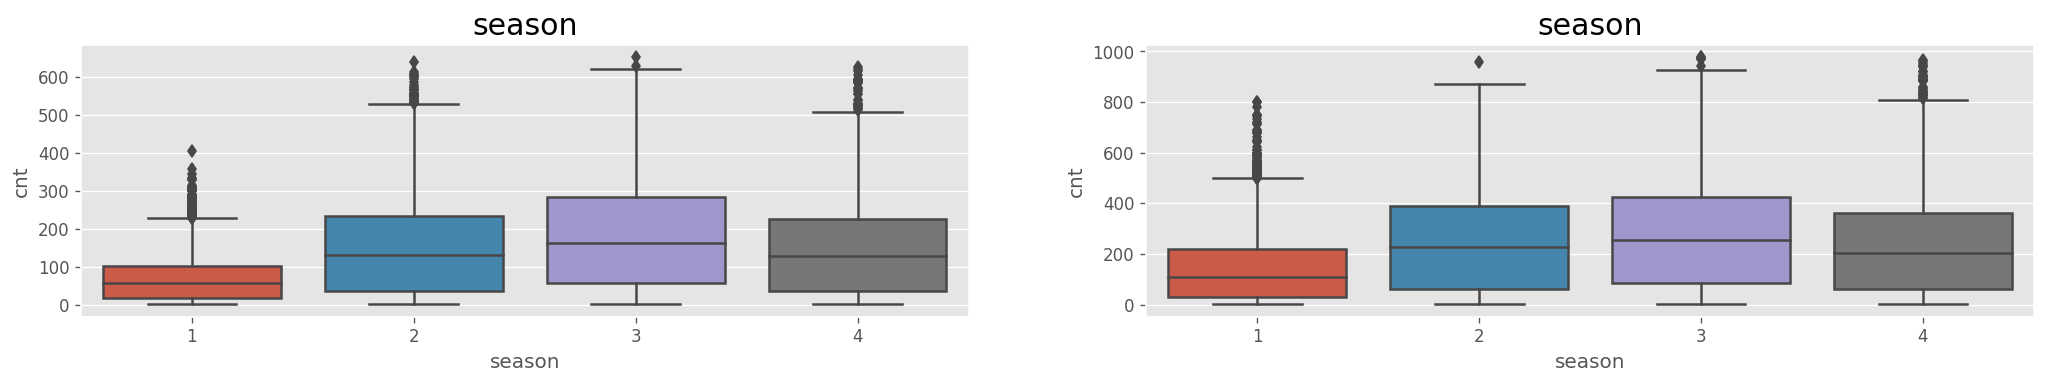

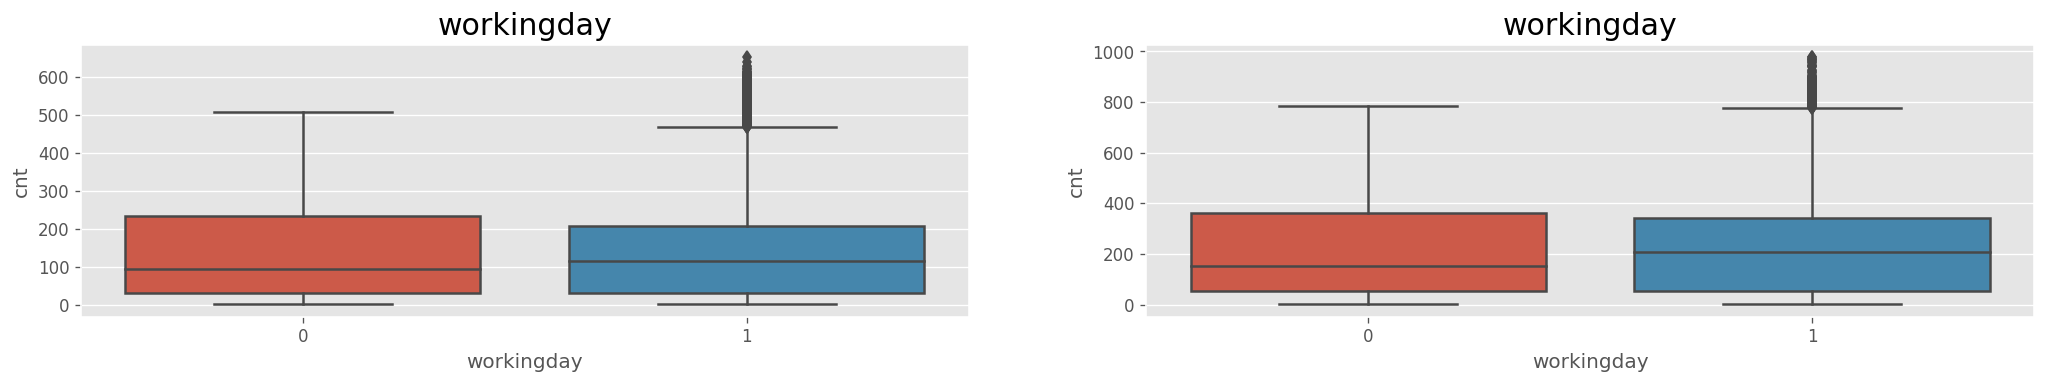

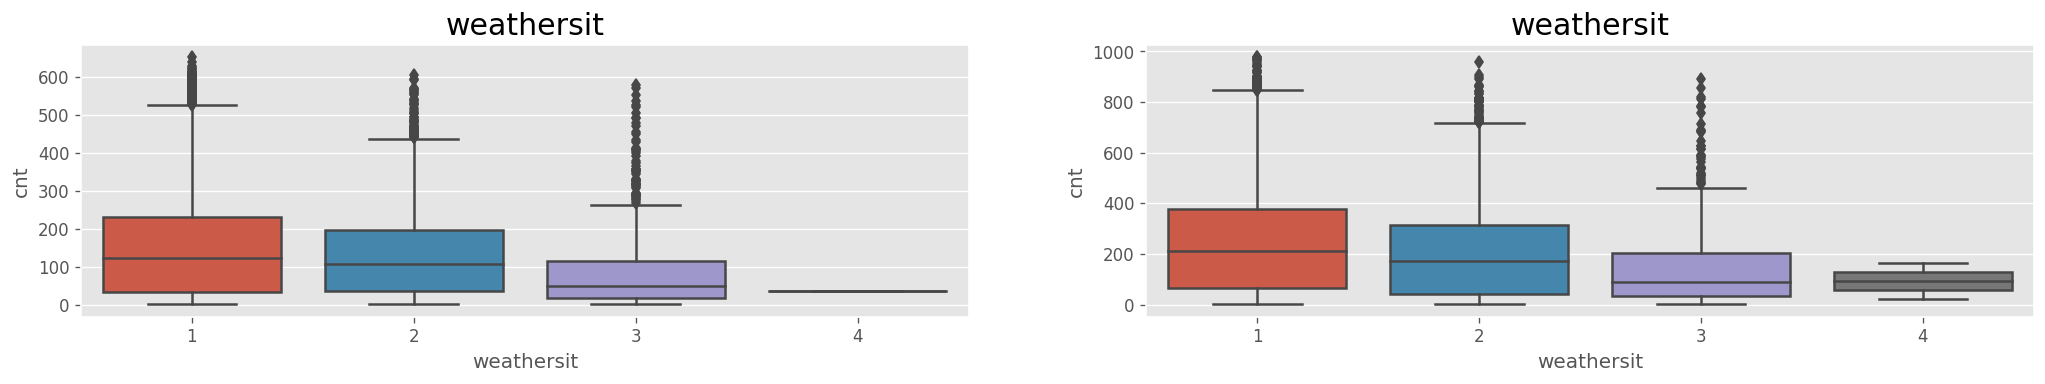

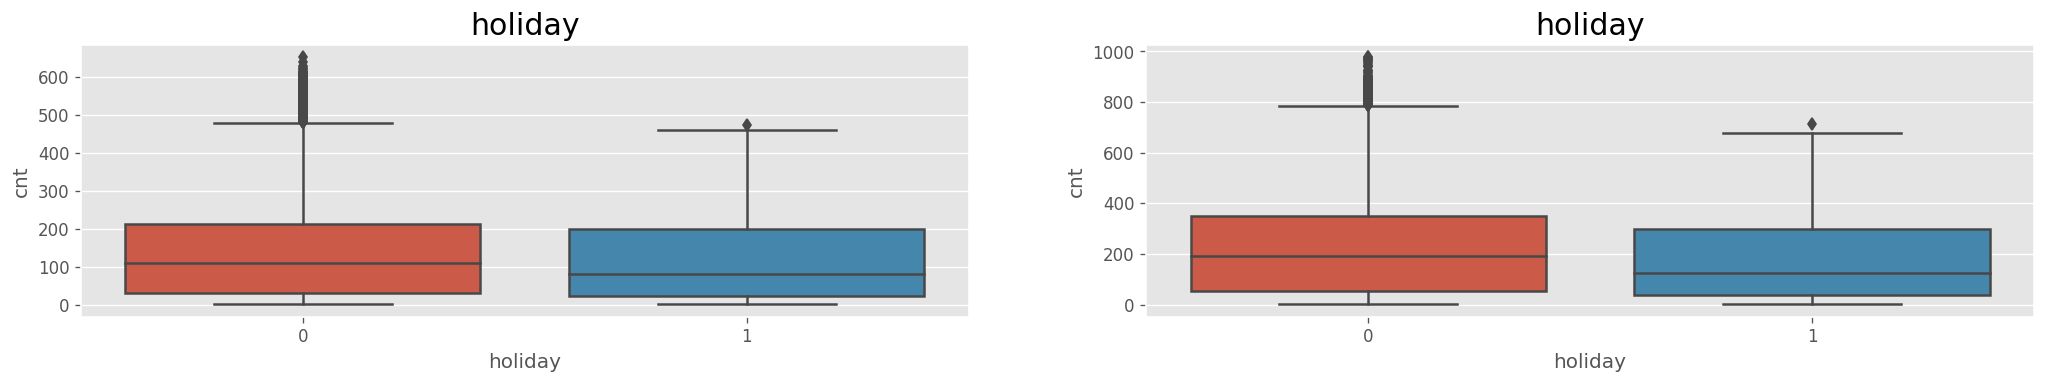

In [ ]:
estaciones = ["season", "workingday","weathersit","holiday"]
for i in (0,1,2,3):
  situacion = estaciones[i]
  fig, axes = plt.subplots(1, 2, figsize=(21,3), dpi=120)
  sns.boxplot(data = df_hour[df_hour.yr == 0], x=situacion, y='cnt',ax=axes[0]);
  sns.boxplot(data = df_hour[df_hour.yr == 1], x=situacion, y='cnt');
  axes[0].set_title(situacion, fontsize=18); 
  axes[1].set_title(situacion, fontsize=18)
  plt.show()

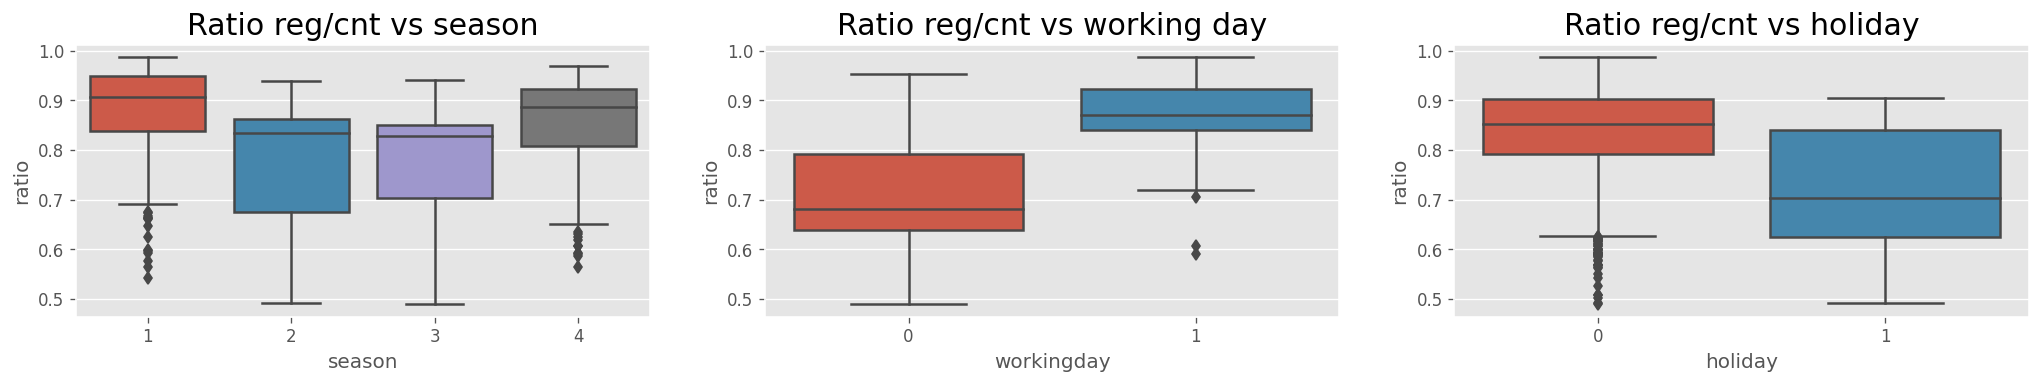

<Figure size 240x240 with 0 Axes>

<Figure size 240x240 with 0 Axes>

<Figure size 240x240 with 0 Axes>

In [ ]:
df_day["ratio"]= (df_day["registered"]/df_day["cnt"])
conditions = ["season", "workingday","holiday"]
fig, axes = plt.subplots(1, 3, figsize=(21,3), dpi=120)
for i in (0,1,2):
  cond = conditions[i]
  plt.figure(figsize=(2,2), dpi=120)
  sns.boxplot(data = df_day,  x=cond, y='ratio', ax =axes[i]);
  axes[0].set_title("Ratio reg/cnt vs season", fontsize=18); 
  axes[1].set_title("Ratio reg/cnt vs working day", fontsize=18)
  axes[2].set_title("Ratio reg/cnt vs holiday", fontsize=18)
plt.show()

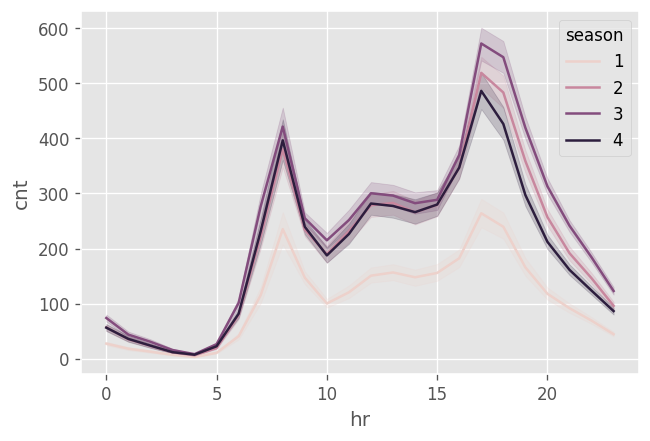

In [ ]:
groups_season_hr = df_hour.groupby([ "hr","season"])
groups_season_hr.tail()
fig, axes = plt.subplots(1, 1,  dpi=120)
sns.lineplot(data = df_hour, hue = "season", x="hr", y='cnt');
plt.show()

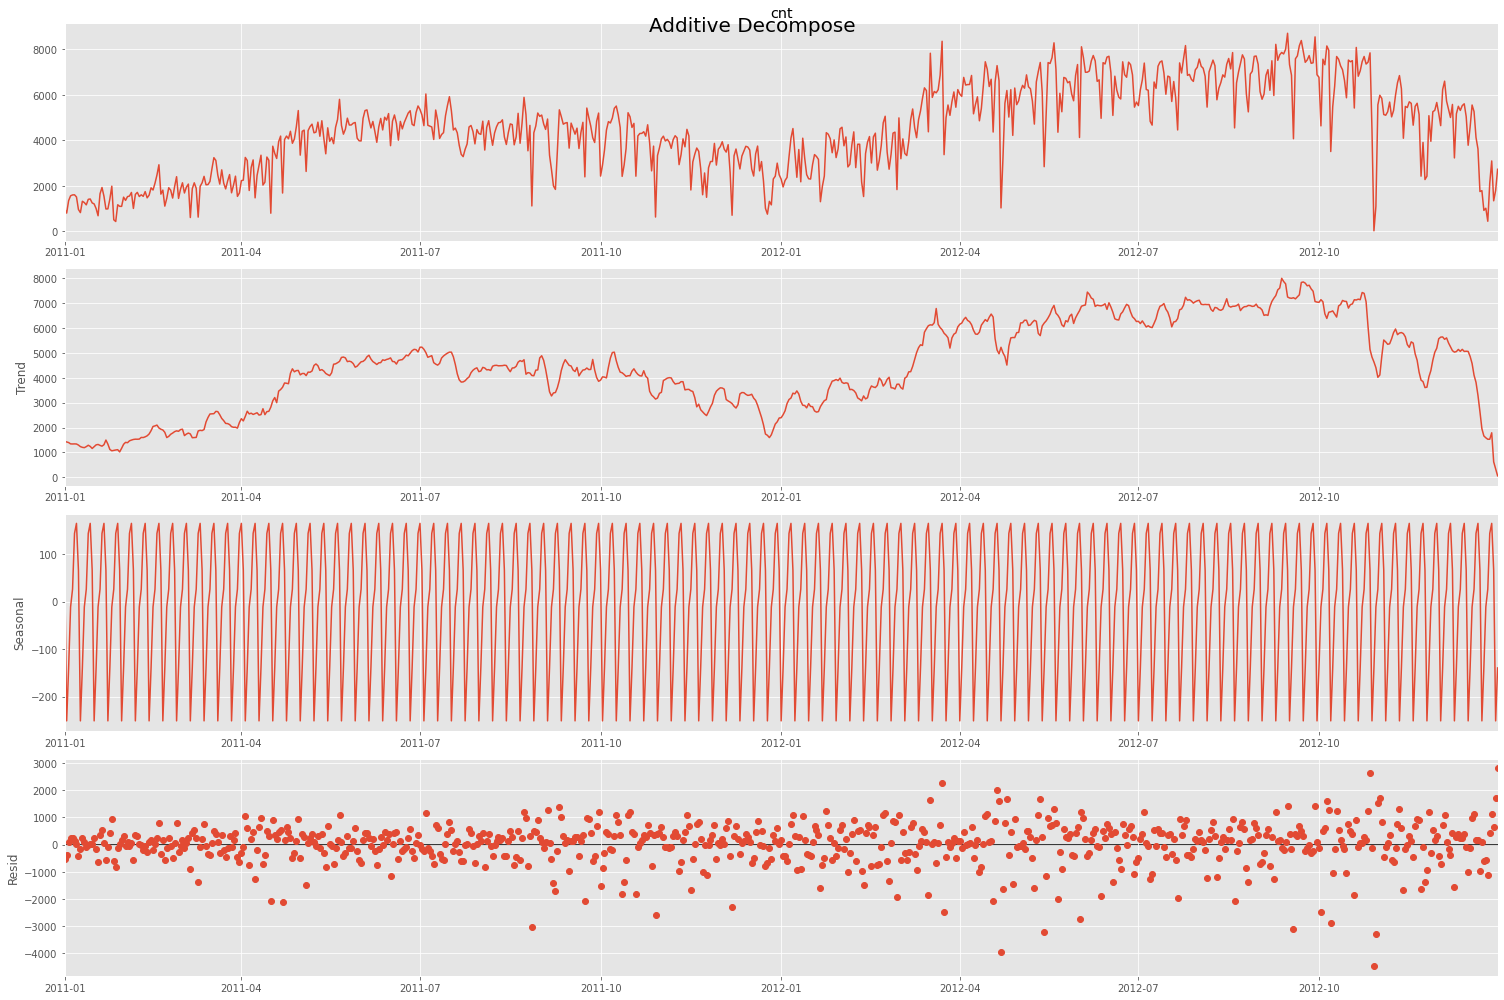

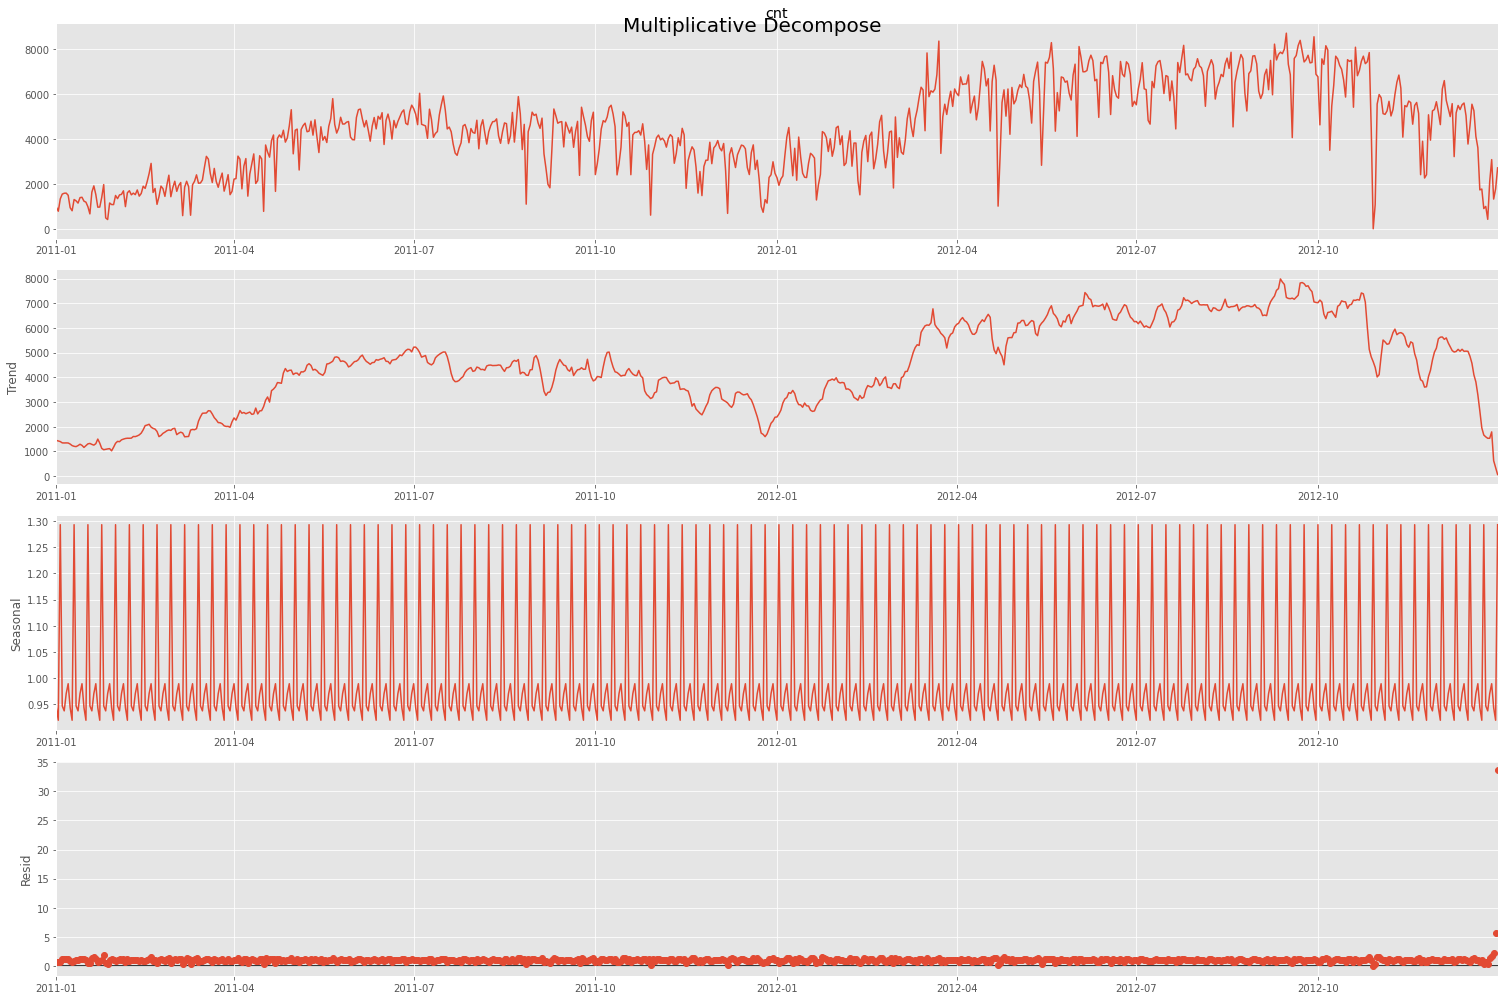

In [ ]:
df_day = pd.read_csv(url, header= "infer", parse_dates= ["dteday"], index_col = ["dteday"])

# Decomposicion aditiva.
result_add = seasonal_decompose(df_day["cnt"], model='additive', extrapolate_trend='freq')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df_day['cnt'], model='multiplicative', extrapolate_trend='freq')

# Graficamos.
plt.rcParams.update({'figure.figsize': (21,14)})
result_add.plot().suptitle('Additive Decompose', fontsize=20)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
plt.show();


Los residuos del modelo multiplicativo parecen estar aleatoriamente distribuidos con media uno, pero para verlo en detalle realizamos un nuevo gráfico. Esta vez acotamos el eje y, ya que el último valor es excepcionalmente alto.

1.062712179712654 1.2381508912806167


<AxesSubplot:xlabel='dteday'>

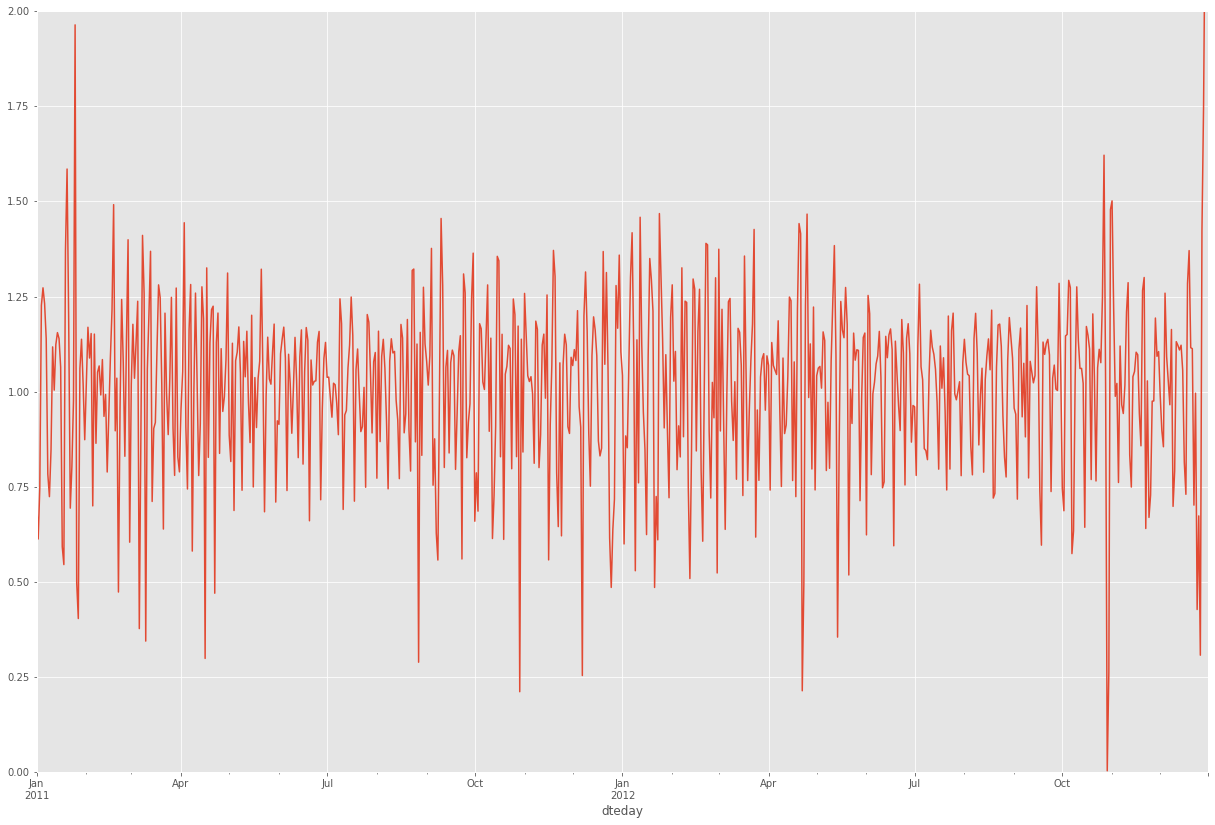

In [ ]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
print(np.mean(df_reconstructed.resid), np.std(df_reconstructed.resid))
df_reconstructed.resid.plot(ylim= (0,2))


Vemos que los residuos (exceptuando el último dato) se mueven al rededor de 1
*   promedio = 1,06
*   desvest = 1,24

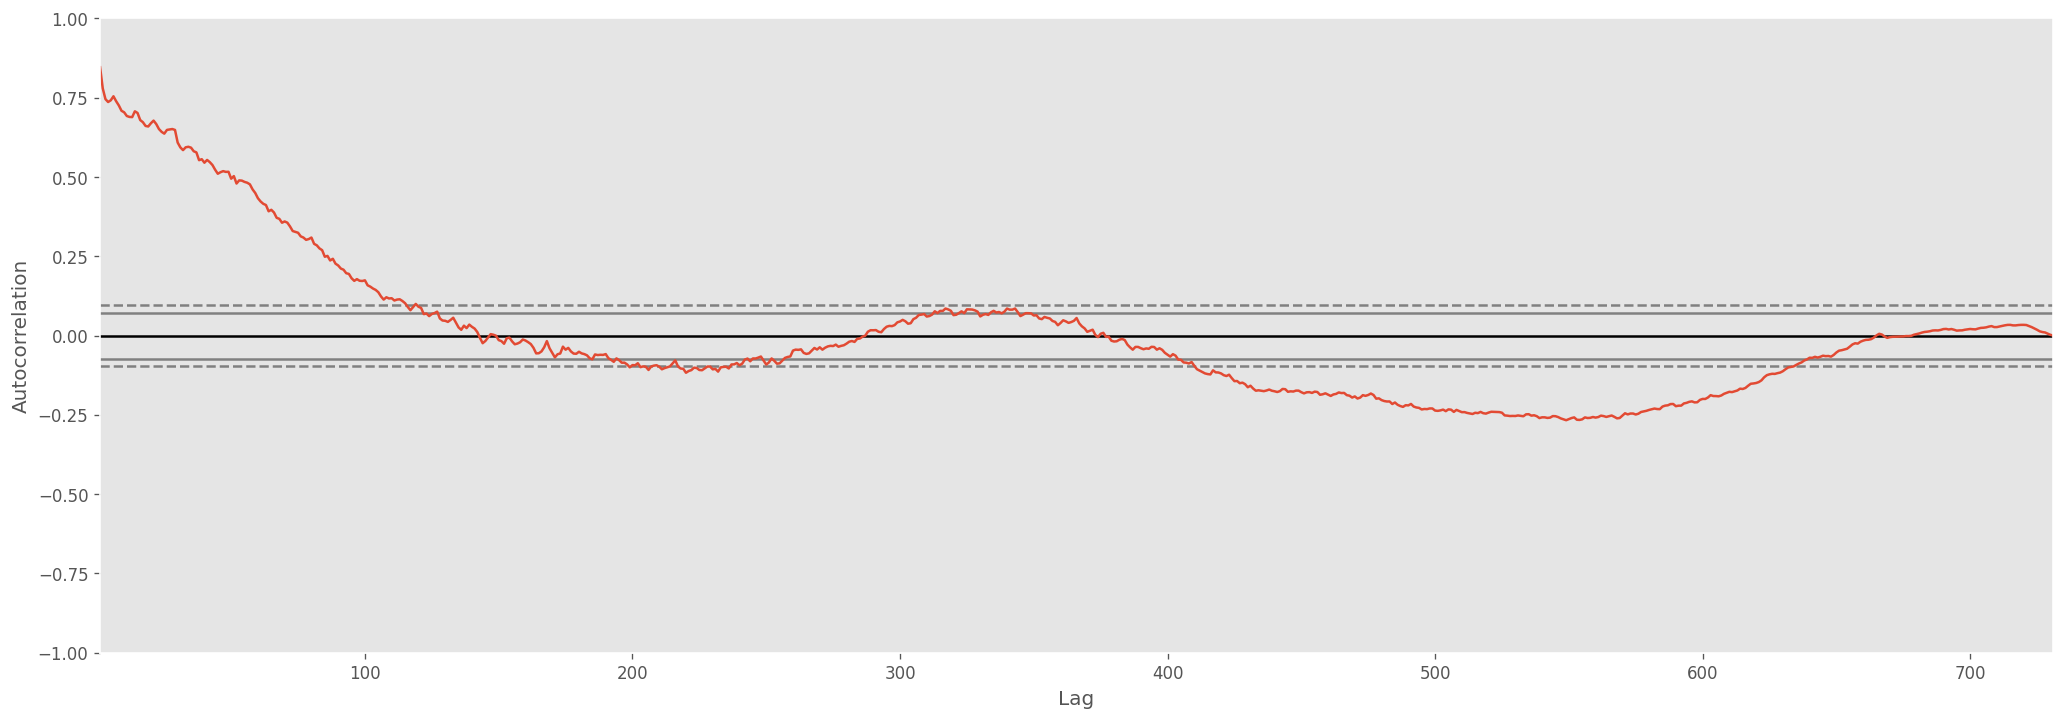

In [ ]:
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})
# Graficamos la funcion de autocorrelacion para la serie de Drug Sales.
autocorrelation_plot(df_day.cnt.tolist());

In [ ]:
len(df_day)/7

104.42857142857143

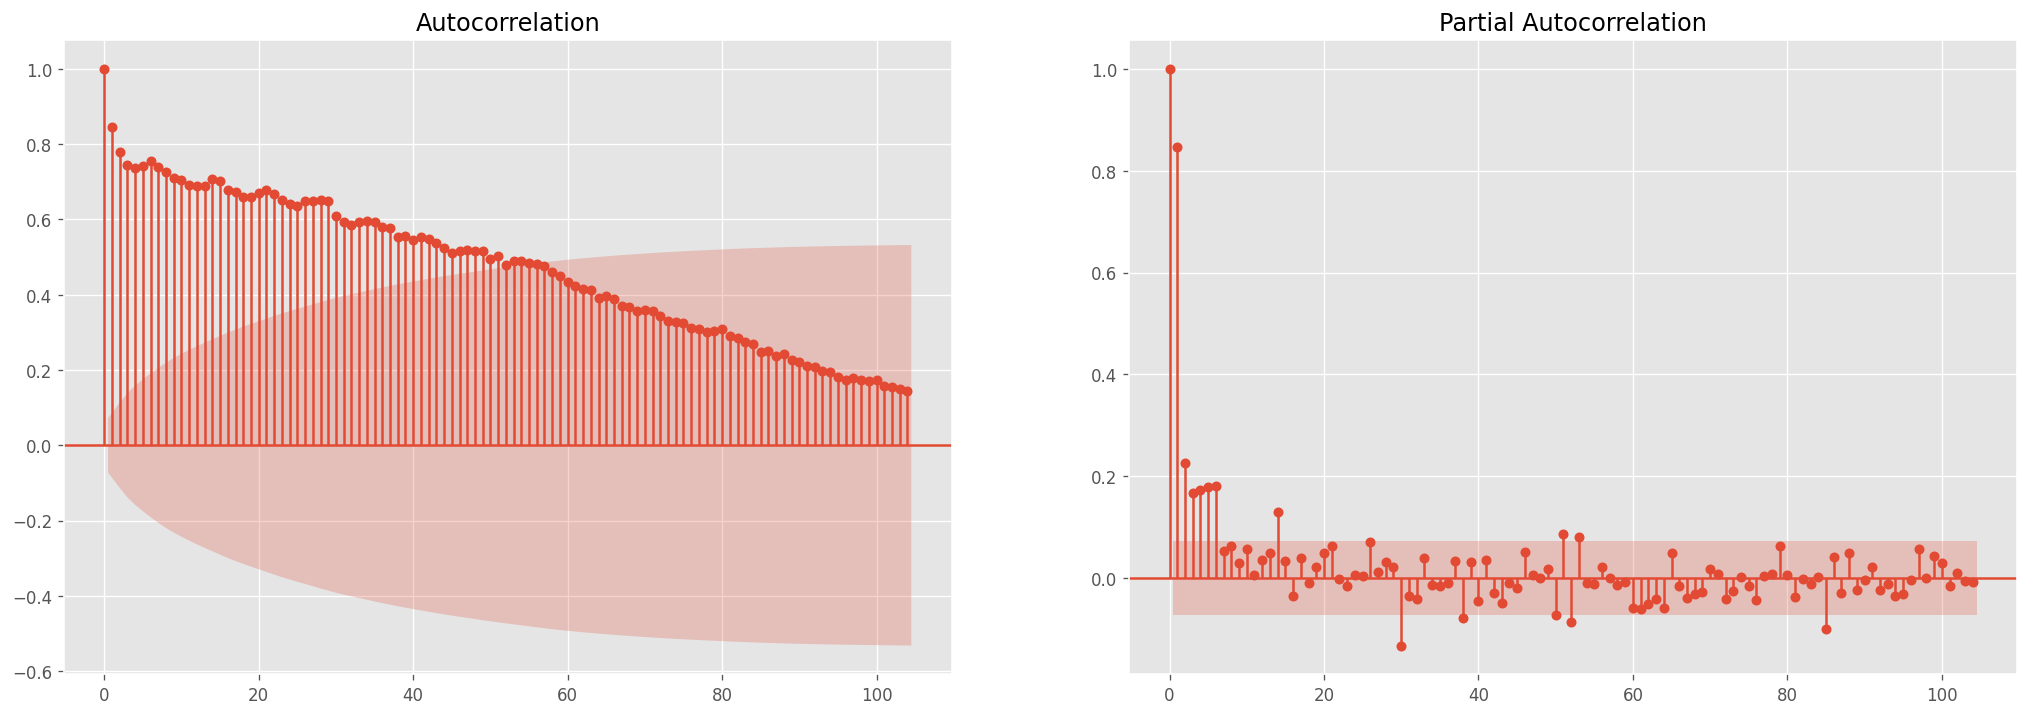

In [ ]:
# Calcula ACF y PACF hasta n lags.
lag = 104
acf_50 = acf(df_day.cnt, nlags=lag)
pacf_50 = pacf(df_day.cnt, nlags=lag)

# Graficamos las funciones.
fig, axes = plt.subplots(1,2,figsize=(21,7), dpi=120)
plot_acf(df_day.cnt.tolist(), lags=lag, ax=axes[0])
plot_pacf(df_day.cnt.tolist(), lags=lag, ax=axes[1]);

La autocorrelación parcial parece mostrar que luego de 7 ciclos se pierde el efecto de autocorrelación -> Es semanal?

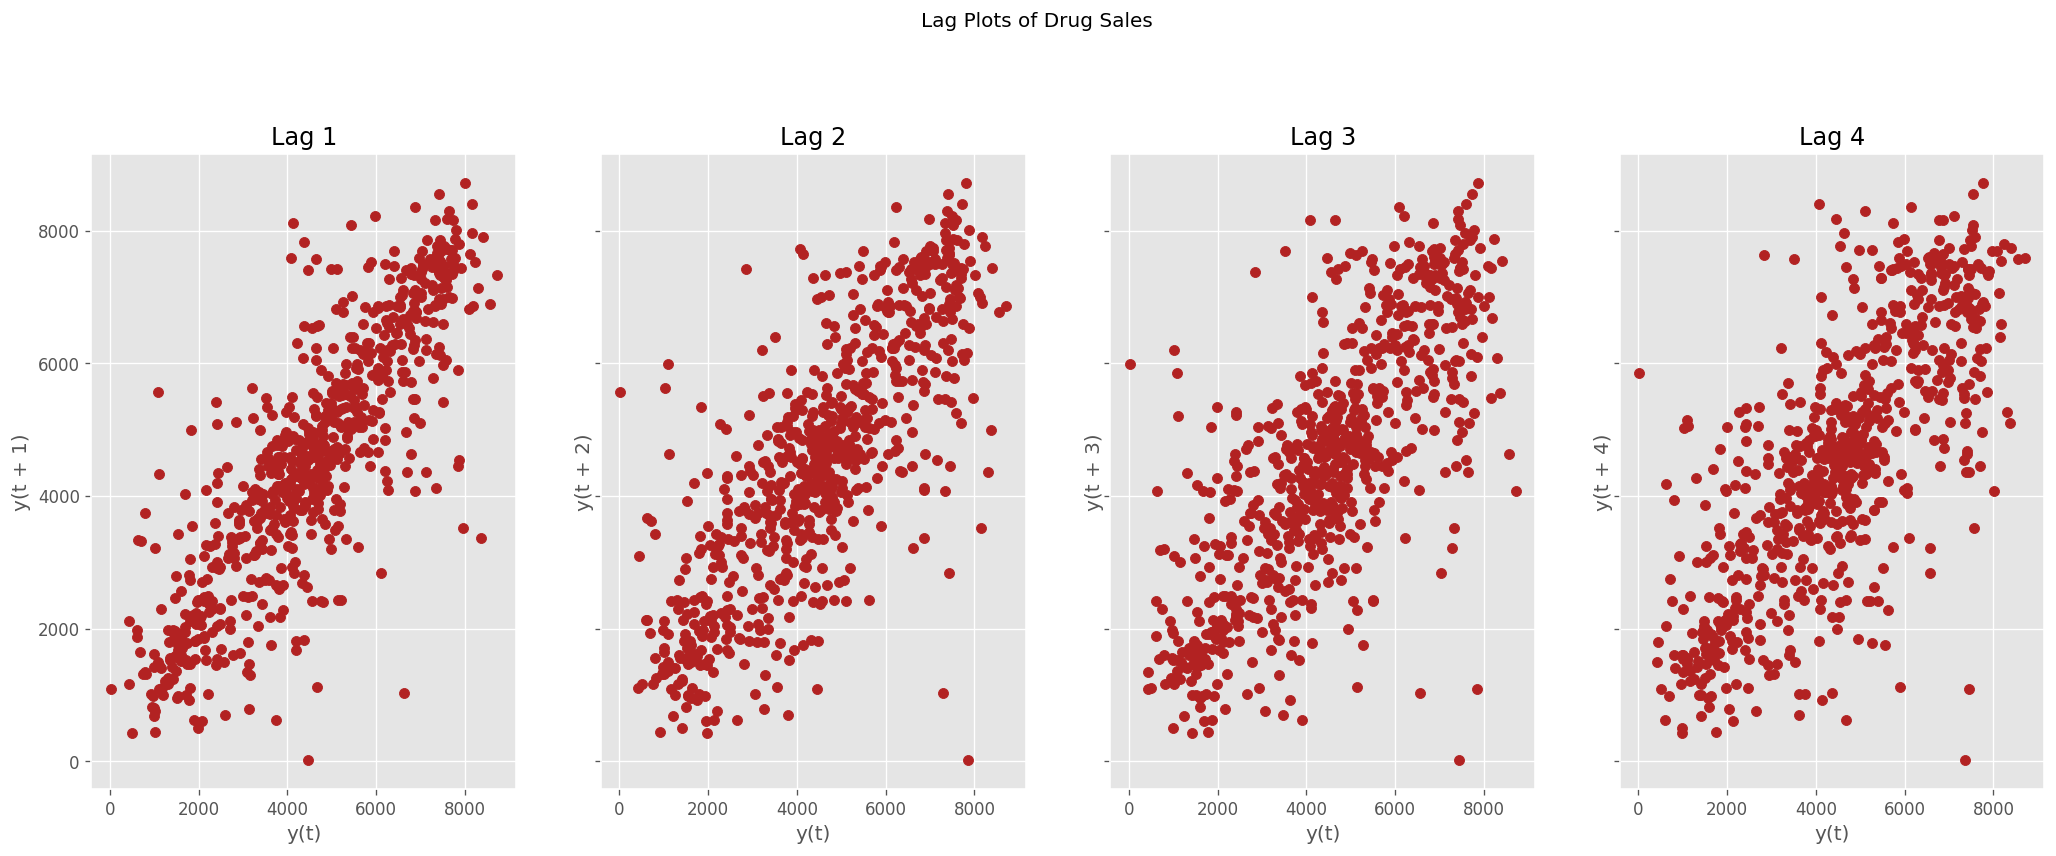

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(21,7), sharex=True, sharey=True, dpi=120)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df_day.cnt, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

Suavizado

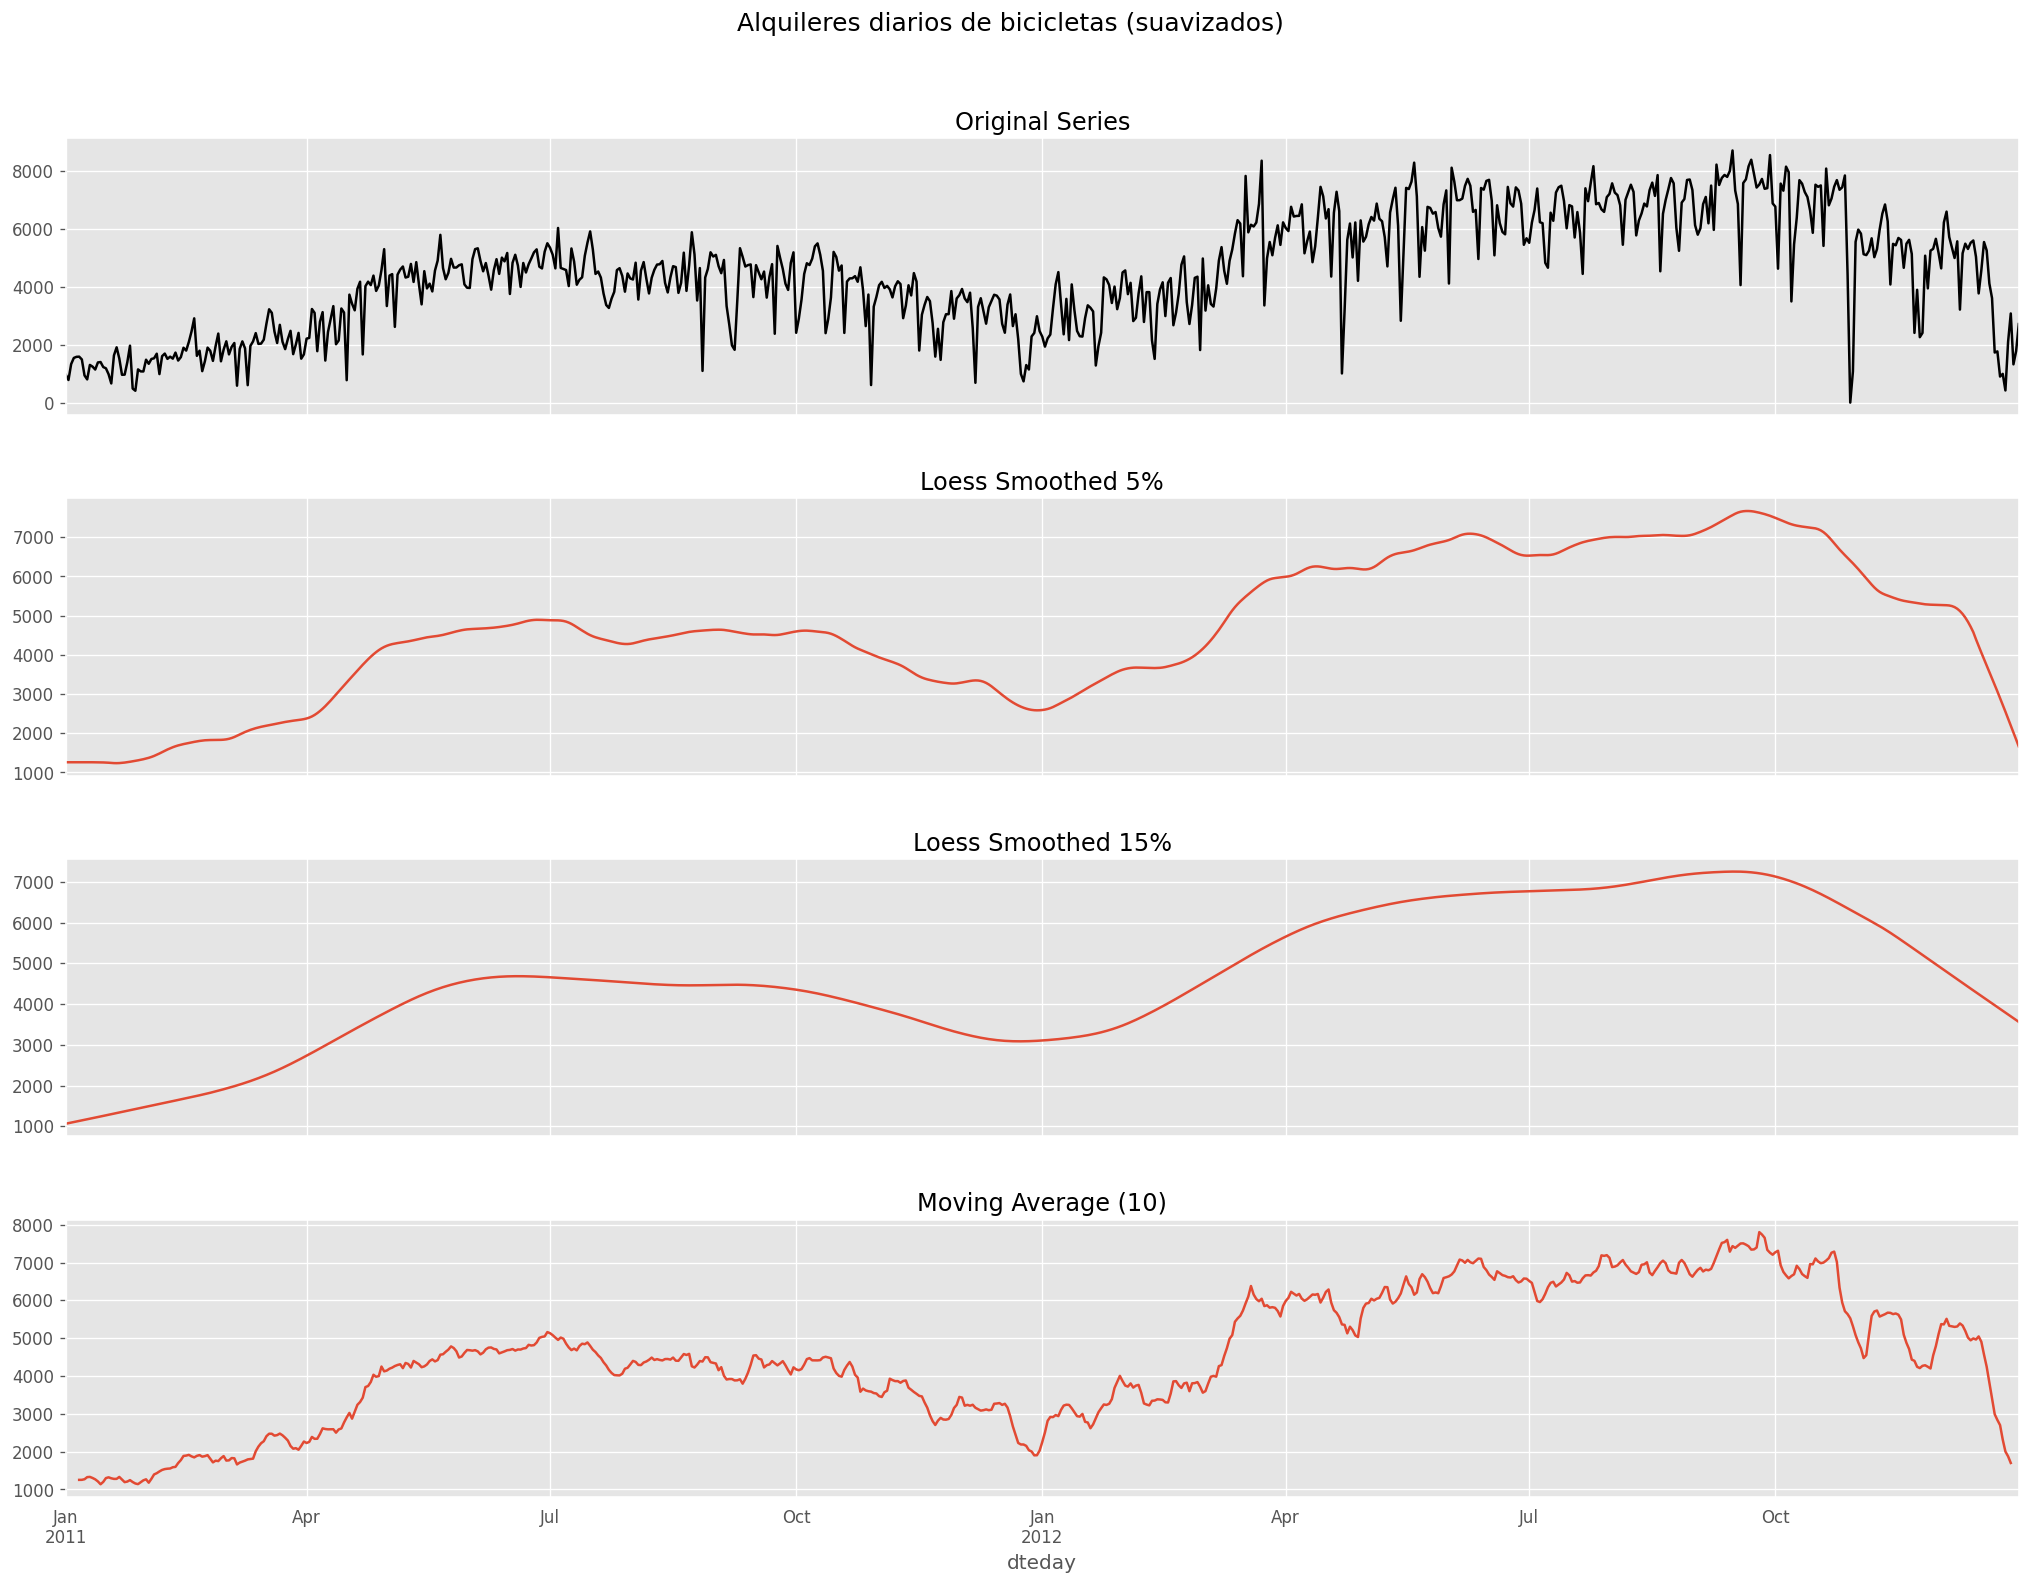

In [ ]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Medias moviles.
df_ma = df_day.rolling(10, center=True, closed='both').mean()

# 2. Loess smoothing (5% y 15%)
df_loess_5 = pd.DataFrame(lowess(df_day.cnt, np.arange(len(df_day.cnt)), frac=0.05)[:, 1], index=df_day.index, columns=['cnt'])
df_loess_15 = pd.DataFrame(lowess(df_day.cnt, np.arange(len(df_day.cnt)), frac=0.15)[:, 1], index=df_day.index, columns=['cnt'])

# Graficamos los tres tipos de suavizado.
fig, axes = plt.subplots(4,1, figsize=(21, 15), sharex=True, dpi=120)
df_day['cnt'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['cnt'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['cnt'].plot(ax=axes[2], title='Loess Smoothed 15%', fontsize=10)
df_ma['cnt'].plot(ax=axes[3], title='Moving Average (10)',fontsize=10 )
fig.suptitle('Alquileres diarios de bicicletas (suavizados)', y=0.95, fontsize=15)
plt.subplots_adjust(hspace = 0.3) 
plt.show()

In [ ]:
# Trabajemos con un dataset de trafico en un sitio web.
result_adf = adfuller(df_hour.cnt)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
result_adf[1]

ADF Statistic: -6.822919
p-value: 0.000000


1.980862627797809e-09

Null hypothesis: Non Stationarity exists in the series.

Alternative Hypothesis: Stationarity exists in the series

In [ ]:
y = df_hour.cnt

## ADF Test
ndiffs(y, test='adf')

0

In [ ]:
# KPSS test
ndiffs(y, test='kpss')  # 0

1

In [ ]:
# PP test:
ndiffs(y, test='pp')

0

Volvemos a la presentación.
### Parámetro p de ARIMA

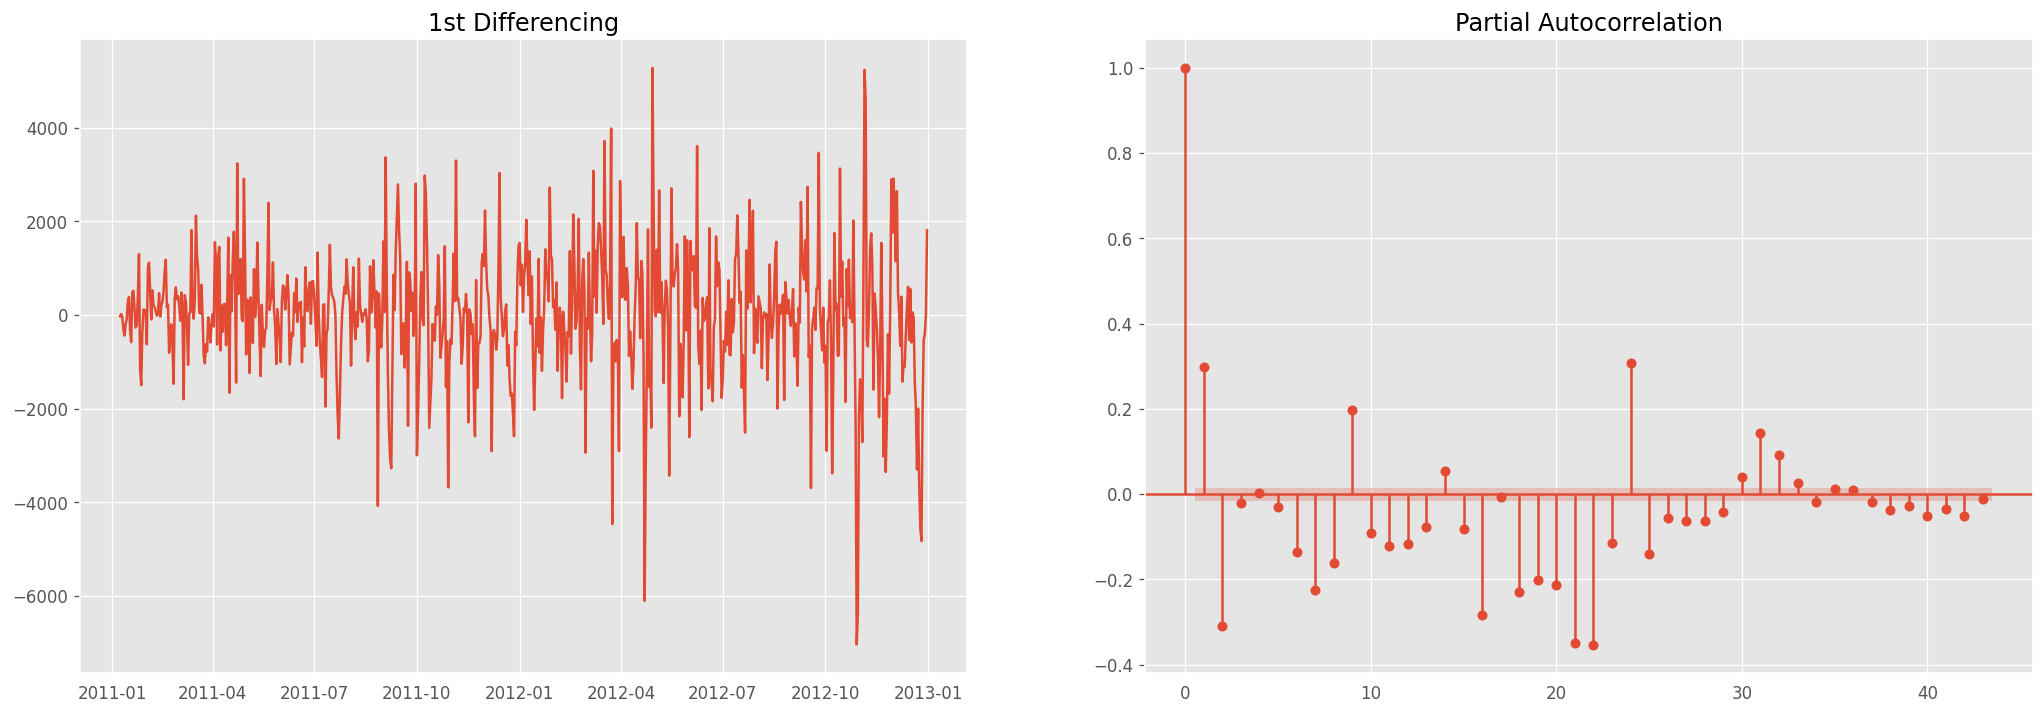

In [ ]:
# Grafico PACF de la primera diferenciacion de la serie nos da una pista de p.
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_day.cnt.diff(7)); axes[0].set_title('1st Differencing')

plot_pacf(df_hour.cnt.diff().dropna(), ax=axes[1])

plt.show()

Ahora vamos a trabajar con el modelo Arima, moviendo sus tres parametros.


1. p: Trend autoregression order.
2.   d: Trend difference order.
3.   q: Trend moving average order.

Hay que tener en cuenta que estos modelos son univariados y no poseen la capacidad de estimar influencias estacionales. Un SARIMA será aplicado luego.
La performance del modelo será evaluado estudiando el parámetro P>|z|

In [ ]:
####Probar varios modelos y evaluar el aic

# 2,1,4 ARIMA Model
model = ARIMA(df_day.cnt, order=(2,1,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.cnt   No. Observations:                  730
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -6017.808
Method:                       css-mle   S.D. of innovations            919.602
Date:                Thu, 09 Dec 2021   AIC                          12053.615
Time:                        22:31:41   BIC                          12094.953
Sample:                    01-02-2011   HQIC                         12069.563
                         - 12-31-2012                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9243      6.180      0.311      0.756     -10.188      14.037
ar.L1.D.cnt     0.3480      0.322      1.082      0.279      -0.283       0.978
ar.L2.D.cnt    -0.7037      0.252     -2.789    

In [ ]:
model.score.summary

AttributeError: ignored

Se fueron agregando parámetros de a uno y analizando la performance de cada modelo, comenzando por p y luego q.



---
Se aplica un modelo SARIMA


In [ ]:
model_sarima = sm.tsa.statespace.SARIMAX(df_day.cnt,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = mod.fit()
print(results_sarima.summary())

NameError: ignored